#Vorbereitung der Umgebung 
Bereitet die Umgebung vor, lädt die nötigen Dependencies und Libraries die im Projekt benötigt werden.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install shap
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

from scipy.ndimage import median_filter
from scipy.signal import wiener
from pykalman import KalmanFilter

#Umwandlung JSON-Request zu CSV
Dieser Code muss nur ausgeführt werden, wenn die Erhebung von Referenzdaten statt mit dem Beacon Backend Projekt, mit hook.ubeac.io erfasst wurden. In diesem Codesegment werden die JSON-Files verarbeitet und die Informationen so aufbereitet, dass diese zu denselben CSV-Files führen wie bei dem Beacon Backend Projekt.

In [ ]:
import glob, os

path = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/"

whitelistMajorMinor = [100029571,100029586,100656666,1000411111,1000422222,1000454480,1230329194]

os.chdir(path+"JSON/")
dictionary_list = []

for jsonFile in glob.glob("*.json"):
  filename = os.path.splitext(jsonFile)[0]

  df = pd.read_json(path+"/JSON/"+filename+".json",)

  #Iterates through all gateway traces
  for traceIndex in range(len(df)):
    currentTrace = df.iloc[traceIndex]
    
    #Splits data string as it is not castable as json string
    #Two step is required to filter out , signs
    traceEntries = currentTrace.content.split('"')[3::2]
    for beaconIndex in range(len(traceEntries)):
      beaconData = traceEntries[beaconIndex].split(',')

      if len(beaconData[4]) >= 56: 
        #Extracts beacon data out of hex value
        beaconType = beaconData[4][6:18]
        uuid = beaconData[4][18:50]
        major = int(beaconData[4][50:54],16)
        minor = int(beaconData[4][54:58],16)
        majorminor = int(str(major)+str(minor))
        timestamp = beaconData[5]

        #Checks if current iteration should be skipped as signal is not of beacons
        if majorminor not in whitelistMajorMinor:
          continue
        #General signal power strength set for beacons
        #The measured power equals the signal strength on 1 meter distance
        measuredPower = -60

        #Specific power was set for beacon with the majorminor value (100656666)
        if majorminor == 100656666:
          measuredPower = -75

        #Id of the tag of the Beacon
        tagId = beaconData[1]
        gateway = beaconData[2]
        rssi = int(beaconData[3])
        
        #Calculates distance with given formula
        distance = (10 ** ((measuredPower - rssi) / (10 * 3)))

        #Creates beacon entry as dictionary entry for efficent dataframe transformation
        beacon = {'_id':tagId, 'distance':distance, 'gateway':gateway, 
                'major':major, 'majorminor':majorminor, 'minor':minor, 
                'rssi':rssi, 'timestamp':timestamp,'type':beaconType,
                'uuid':uuid}
        #Adds beacon to dictionary
        dictionary_list.append(beacon)
#Transforms dicitonary to dataframe (more efficent then concat)
transformedDf = pd.DataFrame.from_dict(dictionary_list)

#Cleaning of dublicates / multi entries which were recived with same timestamp
transformedDf[["distance","rssi"]] = transformedDf.groupby(["timestamp","majorminor","gateway","uuid"])[["distance","rssi"]].transform('median')
transformedDf = transformedDf.drop_duplicates().sort_values(by=["timestamp","gateway"]).reset_index(drop=True)

transformedDf.to_csv(r''+path+"/CSV/CombinedGatewayData.csv", index=False)

#Labeling der Daten (Erweiterung CSV)
In diesem Abschnitt werden die CSV-Dateien welche aus JSON-Requests oder direkt aus einer Datenbank extrahiert wurden mit Labeln erweitert.
Hier zu muss ein LabelHelper.csv File ausgefüllt werden, da diese die Zeitpünkte / Timestamps enthalten man sich wann an welchem Punkt befunden hat um das entsprechende Label zu setzen.

In [ ]:
import glob, os

path = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/"
pathCSV = path+"CSV/"

#Contains timestamp, tag and specific tag values for each measurepoint of data
timestampLabelHeplerDf = pd.read_csv(path+"LabelHelper.csv",sep=";")

os.chdir(pathCSV)

frame = list()

for csvFile in glob.glob("*.csv"):
  df = pd.read_csv(pathCSV+csvFile)

  #This iterates through all data which are within the valid timestamp which are defined in a helper csv file
  for index in range(len(timestampLabelHeplerDf)):
    selection = df.loc[(df.timestamp >= timestampLabelHeplerDf.iloc[index].firsttimestamp) & 
                       (df.timestamp <= timestampLabelHeplerDf.iloc[index].lasttimestamp)].copy()
    selection[["tag","specificTag"]] = timestampLabelHeplerDf.iloc[index][["tag", "specificTag"]]
    frame.append(selection)
  
masterDf = pd.concat(frame).drop_duplicates().reset_index(drop=True)
masterDf.to_csv(r''+pathCSV+"LabeledCombinedGatewayData.csv", index=False)
masterDf.head()

,_id,distance,gateway,major,majorminor,minor,rssi,timestamp,type,uuid,tag,specificTag
0,F0F8F2044F23,0.980121,E06B09BAC79F,10004,1000422222,22222,-59.5,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1
1,DC0D300F720A,1.359356,E06B09BAC79F,12303,1230329194,29194,-64.0,1679222510,1AFF4C000215,D546DF97475747EFBE093E2DCBDD0C77,Room1,M1
2,C630A073DD08,1.107925,E06B09BAC79F,10002,100029586,9586,-60.0,1679222510,1AFF4C000215,0112233445566778899AABBCCDDEEFF0,Room1,M1
3,087CBF000028,1.847850,E06B09BAC79F,10004,1000411111,11111,-68.0,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1
4,04EE03C47286,0.857696,E06B09BAC79F,10004,1000454480,54480,-58.0,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1


#Rohdatenanalyse
In diesem Abschnitt werden die grob aufbereiten Daten eingelesen und visuell aufbereitet um dies zu analysieren.

In [5]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
features = ["distance","rssi","gateway"]
joinParameter = ["type","uuid","tag","specificTag","timestamp","major","majorminor","minor"]

#Training
filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv"
#Test closed Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv"
#Test open Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv"


masterDf = pd.read_csv(filepath)

#Dinamical adapting on number of gateways used for experiment
gateways = masterDf.gateway.unique()

#Creating new Dataframes
adaptedMasterDf = pd.DataFrame()
tempDf = pd.DataFrame()

#Repeat until every Timestamp and Gateway have combined / adapted to oneanother
for gateway in gateways:
  beaconMeasurementsOfGatewayDf = masterDf.loc[(masterDf.gateway == gateway)].copy()
  #Columns which could be used as feature are expanded with Name of Gateway as suffix
  beaconMeasurementsOfGatewayDf.columns = [col + '_' + gateway if col in features else col for col in beaconMeasurementsOfGatewayDf.columns]
    
  #Checks if temp Dataframe already has entries and has to be merged or a copy is "dumped" in
  if len(tempDf) > 0:
    tempDf = pd.merge(tempDf,beaconMeasurementsOfGatewayDf, how='outer', on=joinParameter)
  else:
    tempDf = beaconMeasurementsOfGatewayDf.copy()
adaptedMasterDf = pd.concat([adaptedMasterDf, tempDf])
adaptedMasterDf.drop_duplicates(inplace=True)
tempDf.drop(tempDf.index , inplace=True)
adaptedMasterDf.reset_index(drop=True, inplace=True)

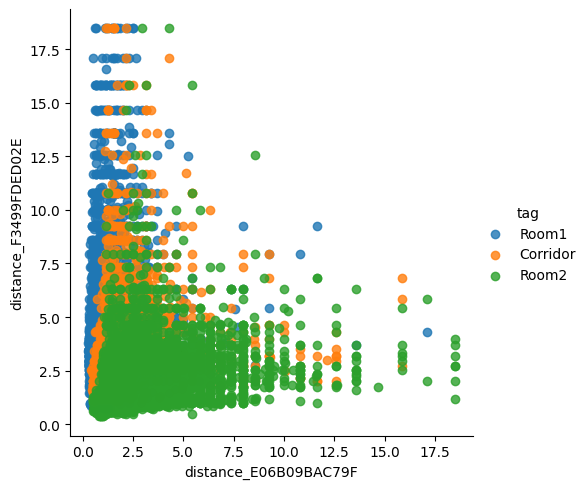

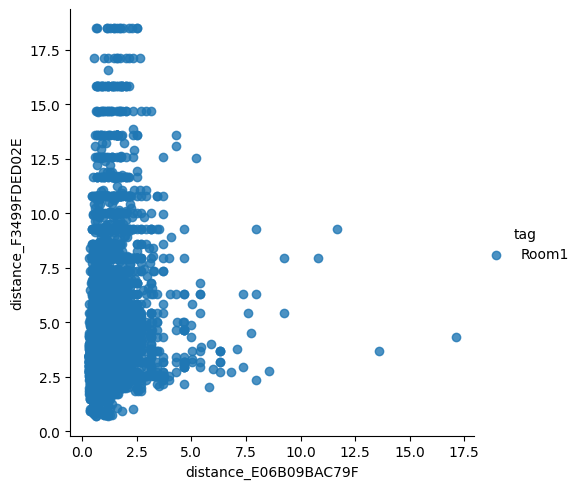

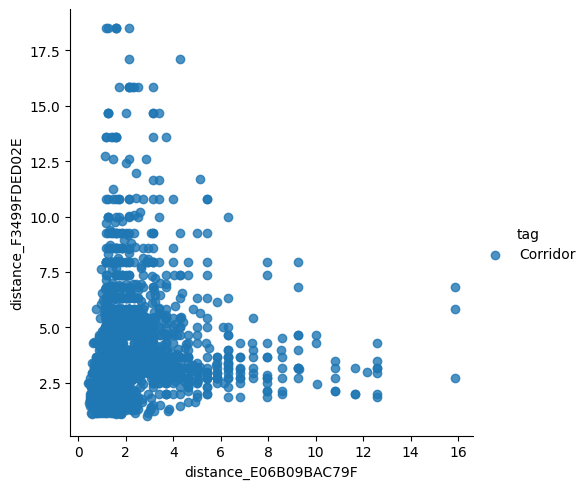

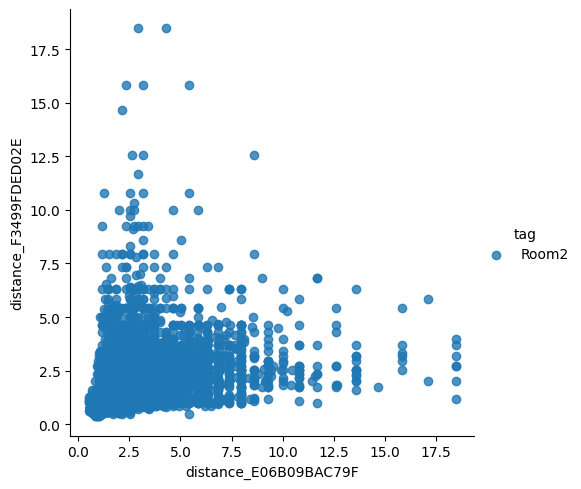

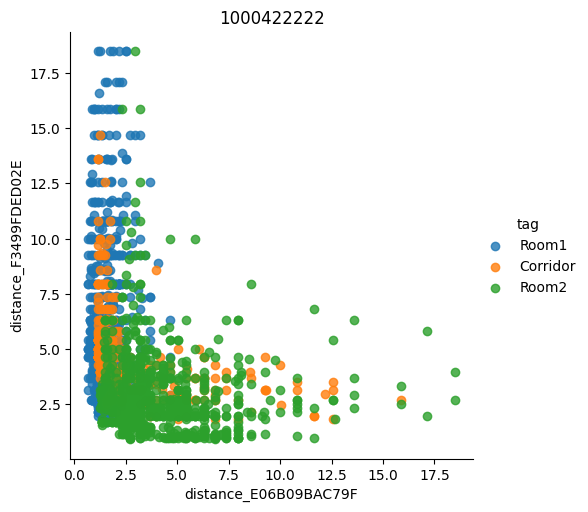

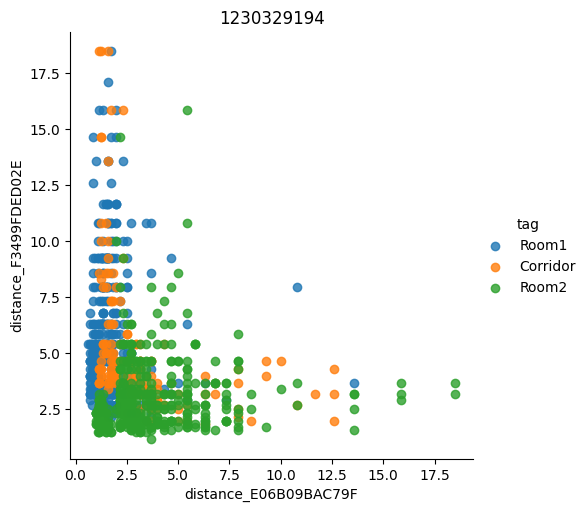

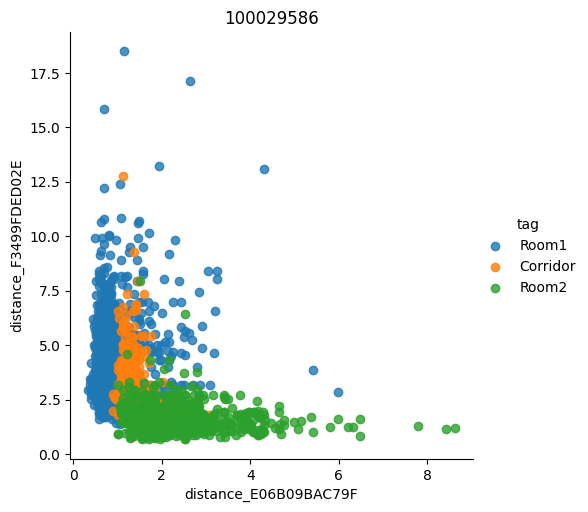

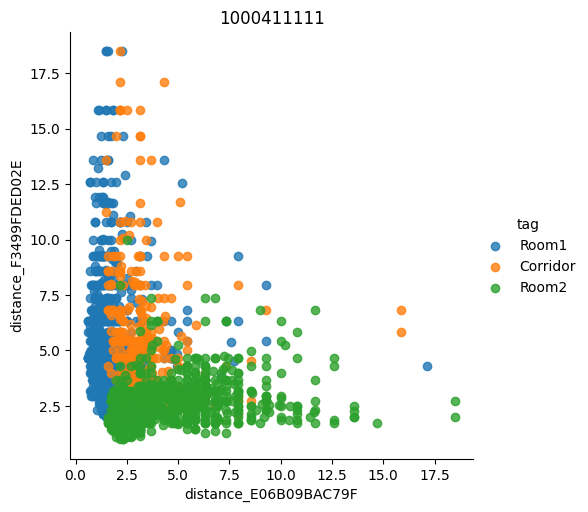

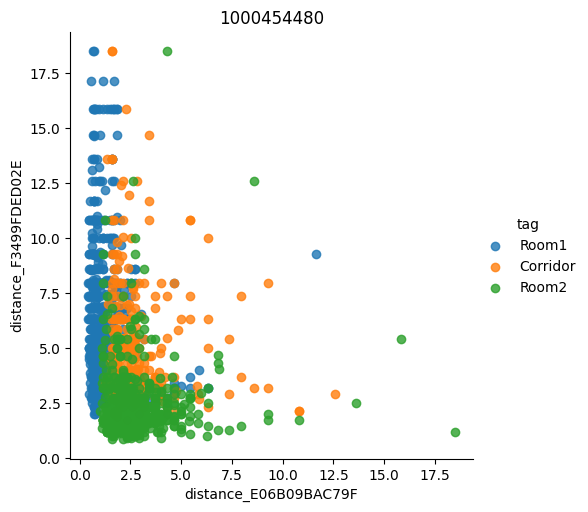

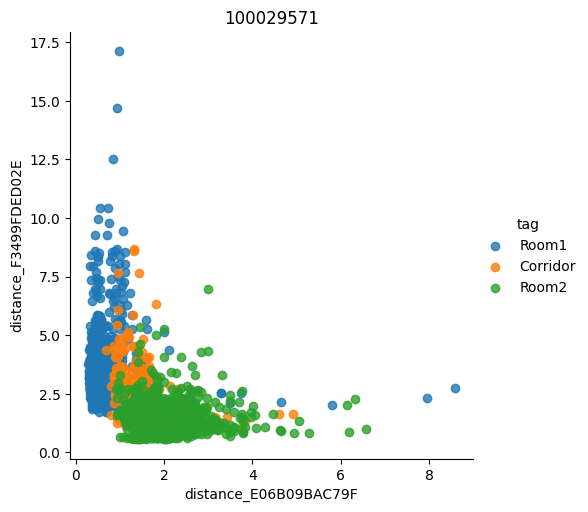

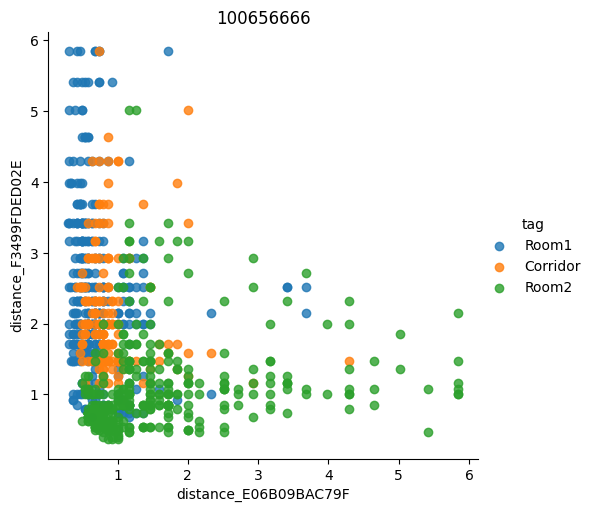

In [6]:
#Selects all columns that start with distance
distance_column_names = [column for column in adaptedMasterDf.columns if column.startswith('distance')]

sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=adaptedMasterDf, hue='tag', fit_reg=False)
for tag in adaptedMasterDf.tag.unique():
  sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=adaptedMasterDf.loc[adaptedMasterDf.tag==tag], hue='tag', fit_reg=False)

plt.show()

for majorminor in adaptedMasterDf.majorminor.unique():
  df = adaptedMasterDf.loc[adaptedMasterDf.majorminor == majorminor]
  sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=df, hue='tag', fit_reg=False)
  plt.title(majorminor)
  
plt.show()
#for tag in adaptedMasterDf.tag.unique():
#  df = adaptedMasterDf.loc[adaptedMasterDf.tag == tag]
#  sns.lmplot(x=rssi_column_names[0], y=rssi_column_names[1], data=df, hue='specificTag', fit_reg=False)
#  plt.show()

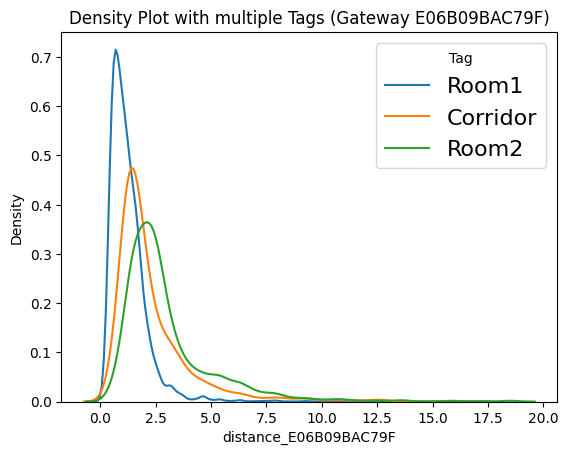

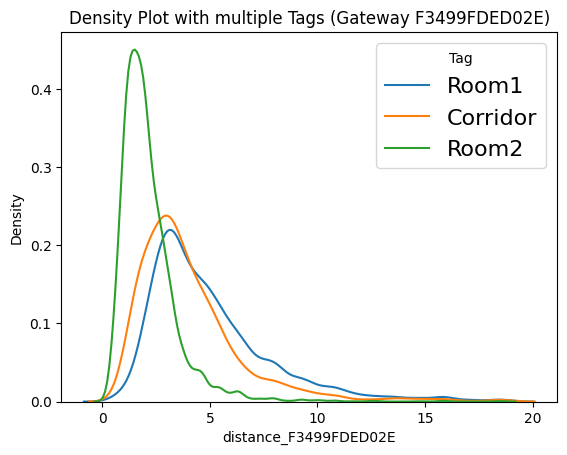

In [7]:
#Gets all tags (can be modified to spefic tags etc)
tags = adaptedMasterDf.tag.unique()
#Selects all columns that start with distance
distance_column_names = [column for column in adaptedMasterDf.columns if column.startswith("distance")]

for distance_column in distance_column_names:
  #Iterates through the tags
  for tag in tags:
    #Subset to the specific tag
    subset = adaptedMasterDf[adaptedMasterDf['tag'] == tag]
    
    #Draw density plot
    sns.kdeplot(subset[distance_column], label = tag)
    
  #Plot formatting
  plt.legend(prop={'size': 16}, title = 'Tag')
  plt.title('Density Plot with multiple Tags (Gateway '+distance_column.split('_')[1]+')')
  plt.xlabel(distance_column)
  plt.ylabel('Density')
  plt.show()

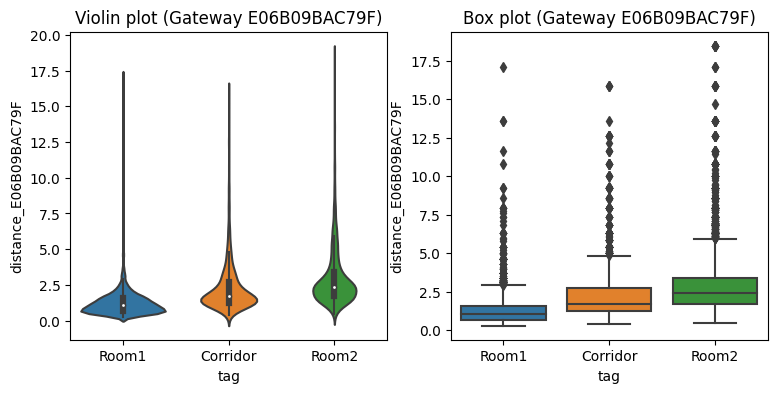

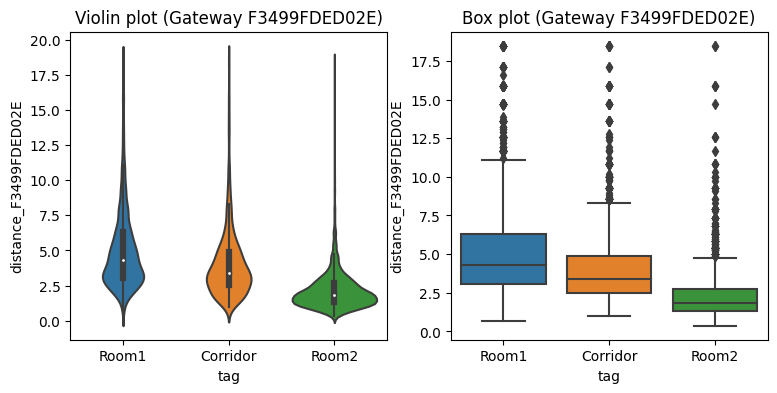

In [8]:
distance_column_names = [column for column in adaptedMasterDf.columns if column.startswith("distance")]

for distance_column in distance_column_names:
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
  
  #Plot violin plot
  asdf = sns.violinplot(ax=axs[0], x='tag', y=distance_column, data=adaptedMasterDf)
  axs[0].set_title('Violin plot (Gateway '+distance_column.split('_')[1]+')')

  #Plot box plot
  sns.boxplot(ax=axs[1], x='tag', y=distance_column, data=adaptedMasterDf)
  axs[1].set_title('Box plot (Gateway '+distance_column.split('_')[1]+')')

  plt.show()

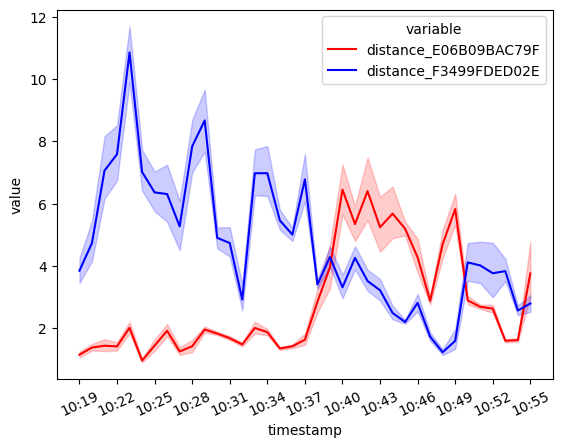

In [9]:
majorminor = adaptedMasterDf.majorminor.unique()
df = adaptedMasterDf.loc[adaptedMasterDf.majorminor == majorminor[0],(distance_column_names + ["timestamp"])]
df.timestamp = pd.to_datetime(df.timestamp,unit='s').dt.strftime('%H:%M')
sample = sns.lineplot(x='timestamp', y='value', hue='variable', 
             data=pd.melt(df, ['timestamp']),
             palette=['red', 'blue'])
             #estimator="median")
sample.set_xticks(sample.get_xticks()[::3])
sample.set_xticklabels(sample.get_xticklabels(), rotation=25)
plt.show()

#Dateneinlesen und -grobaufbereitung
In diesem Abschnitt werden die Daten so aufbereitet, dass diese auf die Modelle angewendet werden können. Sowohl als Trainings- und Testdaten.  

In [4]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
columns_of_interessts = ["distance","gateway","uuid","majorminor","timestamp","tag","specificTag"]

#Mapping used to adapt the current tags with new labels ("InRoom": True / False)
gateway2Tag = {'E06B09BAC79F':'Room1', 'F3499FDED02E':'Room2'}

#Create new master dicitonary seperated by gateways
masterDict = dict()

#Training
filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv"
#Test closed Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv"
#Test open Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv"

#Load and secure clean data
masterDf = pd.read_csv(filepath).drop_duplicates().reset_index(drop=True)

#Load Gateways
gateways = masterDf.gateway.unique()

for gateway in gateways:
  tempDf = masterDf.loc[masterDf.gateway == gateway].copy()
  tempDf.distance = tempDf.distance.round(3)
  tempDf['InRoom'] = [1 if (gateway2Tag.get(gateway) == tag) else 0 for tag in tempDf.tag]
  masterDict[gateway] = {'data': tempDf}

#Datenfilterung, -aufbereitung und non Machine Learning Ansatz
In diesem Bereich werden unterschiedliche Filter für die Datenaufbereitung genutzt und verglichen. Anhand diesen Filtern soll auch eine erste **non** Machine Learning Modell erstellt werden. Dies kann auch für die darauffolgenden Modellen als Benchmark verwendet werden.

In [5]:
#Define window size for filter
window_size = 10

distance_raw = 'distance'
distance_moving_median = 'distance_MMedian'
distance_moving_mean = 'distance_MMean'
distance_wiener = 'distance_Wiener'
distance_kalman = 'distance_Kalman'

dict_filter_distance_columns = {'Raw':distance_raw, 'MMedian': distance_moving_median, 'MMean': distance_moving_mean,
                     'Wiener': distance_wiener, 'Kalman': distance_kalman}

for key in masterDict.keys():
  tempDf = masterDict[key]['data']
  for majorminor in tempDf.majorminor.unique():
    distance = tempDf.loc[(tempDf.majorminor == majorminor)].distance
    #Moving Median filter
    arrayDistanceMovingMedian = distance.rolling(window=window_size).median().to_numpy()
    tempDf.loc[(tempDf.majorminor == majorminor), distance_moving_median] = arrayDistanceMovingMedian.round(3)
    #Sliding Window / moving mean filter
    arrayDistanceMovingMean = distance.rolling(window=window_size).mean().to_numpy()
    tempDf.loc[(tempDf.majorminor == majorminor), distance_moving_mean] = arrayDistanceMovingMean.round(3)
  
    #Wiener Filter
    arrayDistanceWiener = wiener(distance.to_numpy(),mysize=window_size)
    tempDf.loc[(tempDf.majorminor == majorminor), distance_wiener] = arrayDistanceWiener.round(3)
  
    #Kalman filter
    #Uses standard setting and EM algorithmen to optimize em variables such as via .em function
    #transition_covariance, observation_covariance, initial_state_mean and initial_state_covariance
    kf = KalmanFilter()
    #n_iter prevents overfitting of EM fitting and smooth predicts rssi values
    #[0][:,0] selects the predicted rssi values of the returned array
    arrayDistanceKalman = kf.em(distance, n_iter=5).smooth(distance)[0][:,0]
    tempDf.loc[(tempDf.majorminor == majorminor), distance_kalman] = arrayDistanceKalman.round(3)
  masterDict[key]['data'] = tempDf

divide by zero encountered in true_divide


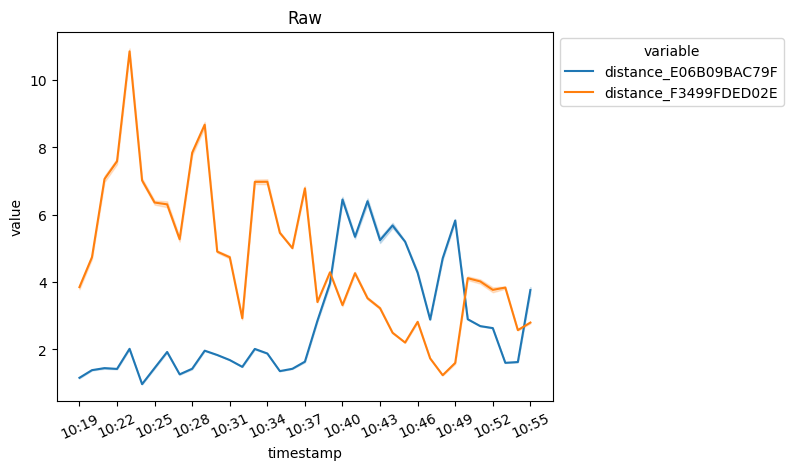

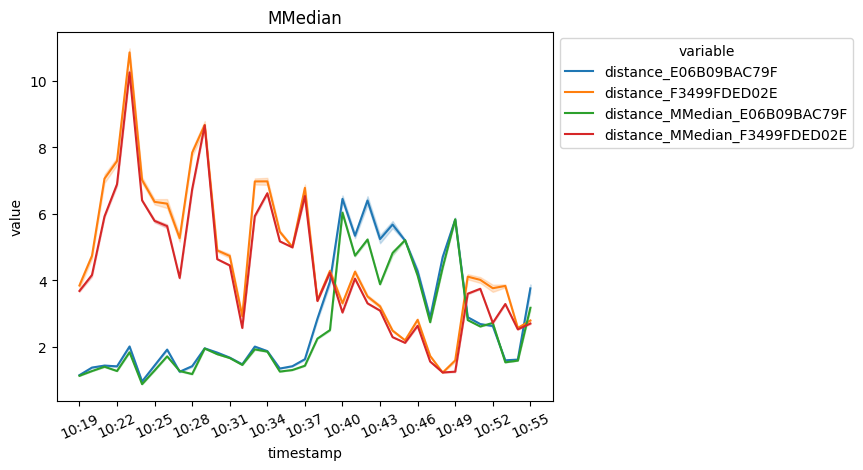

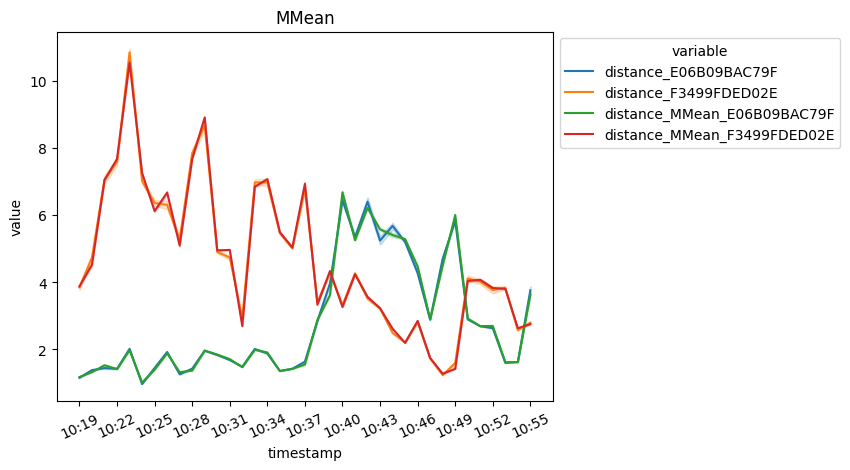

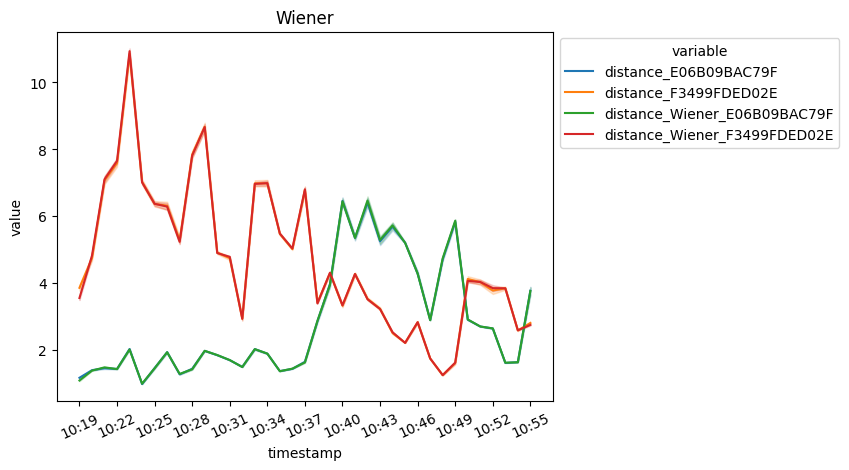

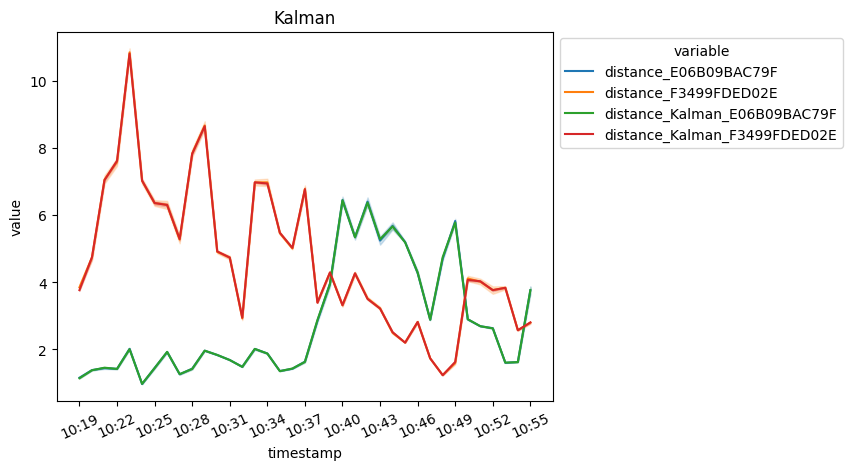

In [6]:
#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
selectedMajorminor = masterDf.majorminor.unique()[0]

for key in dict_filter_distance_columns.keys():
  #Predefine column selection for plots
  columnSelection = ['distance'] + [dict_filter_distance_columns.get(key)] + ['timestamp']
  df = pd.DataFrame(columns=columnSelection)
  for gateway in masterDict.keys():
    #Load data
    tempDf = masterDict.get(gateway).get('data')
    #Reducing entry for specified majorminor and columns
    tempDf = tempDf.loc[tempDf.majorminor == selectedMajorminor,columnSelection]
    #Casting timestamp to a certain format for illustration
    tempDf.timestamp = pd.to_datetime(tempDf.timestamp,unit='s').dt.strftime('%H:%M')
    #Preparation for different naming in plot
    tempDf = tempDf.rename(columns={c: c+'_'+gateway for c in tempDf.columns if c.startswith('distance')})
    if len(df) > 0:
      df = pd.merge(tempDf, df,on=['timestamp'],how='outer')
    else:
      df = tempDf
  #Used for df mutation for direct polting
  df = pd.melt(df, ['timestamp']).sort_values(['timestamp','variable'])
  ax = sns.lineplot(x='timestamp', y='value', hue='variable', 
                    data=df)
  #Setting three minutes jumps in timestamp and other stylings on x-axies 
  ax.set_xticks(ax.get_xticks()[::3])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
  plt.title(key)
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
  plt.show()


#Featureerweiterung (Feature Generation)
In diesem Abschnitt werden aus den bestehenden Daten Features generiert. Dies soll ermöglichen, dass nicht nur ein Distanzeintrag an das Modell gesendet wird. So wird die Featureanzahl von 1 auf n erhöht.
Dabei werden verschiedene Anzahlen an zusätzlichen Features ausgetestet.

In [13]:
#Defines amount of additional feature values
enlargement_size = 5

#Predefines names and generates the column lists of new features
additonalCols = []
timediffCols = []
featureCols = list(dict_filter_distance_columns.values())
for index in range(enlargement_size,0,-1):
  additonalCols = additonalCols + [sub +'-prev'+str(index) for sub in featureCols]
  timediffCols = timediffCols + ['timediff-prev'+str(index)]

newDf = pd.DataFrame()

for key in masterDict.keys():
  df = masterDict.get(key).get('data')
  for majorminor in df.majorminor.unique():

    #Selects each beacon seperatly for clean data preparation
    tempDf = df.loc[df.majorminor == majorminor].copy().reset_index(drop=True)

    #Defines boundries for clean iteration through current dataframe
    lowerBoundry = enlargement_size
    upperBoundry = len(tempDf)
    

    for currentPosIndex in range(lowerBoundry,upperBoundry):
      refTimestamp = tempDf.iloc[currentPosIndex].timestamp
      refInRoom = tempDf.iloc[currentPosIndex].InRoom

      #Selects the n previous df entries before the current df entry
      dfSection = tempDf.iloc[(currentPosIndex-enlargement_size):currentPosIndex]

      #If Label InRoom is NOT the same it should lead to a sum of more than 0
      #in this case current iteration is skipped as it can not be used for training
      if sum(dfSection.InRoom != refInRoom) > 0:
        continue

      #Current timestamp gets substracted of each entry seperatly
      timediffs = dfSection.timestamp - refTimestamp
      additionalFeatures = dfSection.loc[:,featureCols]

      #Useage of col order and array transforming (reshaping) for direct assigning of values
      #As it is set for a single df entry shape has to be (n,1)
      tempDf.loc[tempDf.index == currentPosIndex,timediffCols] = timediffs.to_numpy().T
      tempDf.loc[tempDf.index == currentPosIndex,additonalCols] = additionalFeatures.to_numpy().reshape(len(additonalCols))       
        

      #"Simpler" solution but extremly imperformant
      #Above solution is 7 times faster

      #for index in range(1,enlargement_size+1):
        
      #  additionalFeatureIndex = currentPosIndex - index
        #Abort current iteration as it should just use reference points within same label (InRoom)
      #  if (refInRoom != tempDf.iloc[additionalFeatureIndex].InRoom):
      #    continue
      #  timediff = tempDf.iloc[additionalFeatureIndex].timestamp - refTimestamp
        
      #  additonalCols = [sub +'-prev'+str(index) for sub in featureCols]
      #  distances = tempDf.loc[tempDf.index == additionalFeatureIndex,featureCols]

      #  tempDf.loc[tempDf.index == currentPosIndex,additonalCols] = distances.to_numpy()
      #  tempDf.loc[tempDf.index == currentPosIndex,['timediff-prev'+str(index)]] = timediff

    #Cleans df and drops all rows which contain a single nan value
    tempDf = tempDf.dropna()
    #Checks if df has already entries and has to be concated with them or new assigned
    if len(newDf) > 0:  
      newDf = pd.concat([newDf, tempDf], ignore_index=True)
    else:
      newDf = tempDf.copy()
  #Writes created data to master dictionary
  masterDict[key]['extended_data'] = newDf

#Machine Learning Algorithmen Training
Beinhaltet die unterschiedlichen Machine Learning Ansätze, welche für die Trainingsdatensätze geprüft werden.

Geplant: KNN, Naive Bayes, Support Vector Classifier (SVC) und Random Forest Classifier

In [8]:
#Set answer to every question as random state (as it is a number used for randomization)
random_state=42

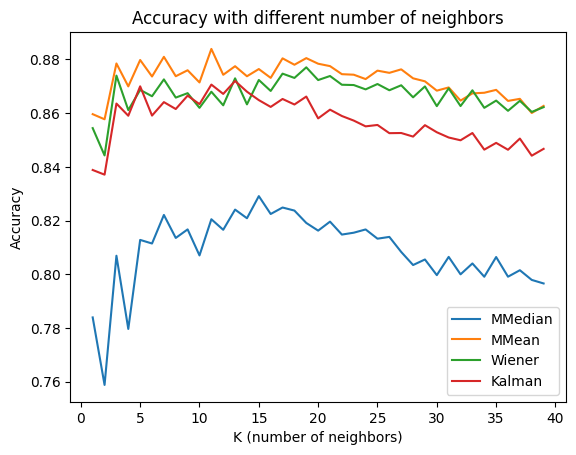

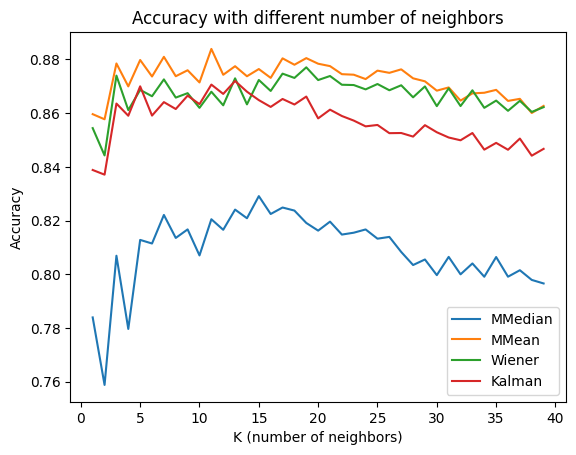

In [14]:
for gateway in masterDict.keys():
  #Loads limited amount of data due to errors (Session break downs and nan scoring values)
  df = masterDict.get(gateway).get('extended_data').head(2000)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_accuaracy = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  optimized_knn_model = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  k = []

  #Exclude Raw data as it leads to index out of bounds for knn algorithm
  dict_accuaracy.pop('Raw', None)
  optimized_knn_model.pop('Raw', None)

  #Check different number of neighbors
  for n_neighbors in range(1, 40):
    #Use a nearest neighbor classifier to evaluate the methods
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    k.append(n_neighbors)

    for filter in dict_accuaracy.keys():
      prefix = str(dict_filter_distance_columns.get(filter))
      columnSelection = [col for col in df if (col.startswith(prefix) or col.startswith('timediff'))]

      X = df.loc[:,columnSelection]
      Y = df.InRoom

      kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)

      crossv_results = cross_val_score(knn, X, Y, cv=kfold, scoring='f1')
      crossv_results = crossv_results[np.isfinite(crossv_results)]

      #Append entry to list
      dict_accuaracy[filter] = dict_accuaracy[filter] + [crossv_results.mean()]

      if (len(optimized_knn_model[filter])==0) or (optimized_knn_model[filter]["best_score_"] < [crossv_results.mean()]) :
        optimized_knn_model[filter] = {"best_score_": [crossv_results.mean()],
                                    "best_params_": {"n_neighbors": n_neighbors}}

  masterDict[gateway]['knn'] = optimized_knn_model

  for key in dict_accuaracy.keys():
    plt.plot(k, dict_accuaracy[key])
  plt.ylabel("Accuracy")
  plt.xlabel("K (number of neighbors)")
  plt.legend(dict_accuaracy.keys(), loc='lower right')
  plt.title("Accuracy with different number of neighbors")
  plt.show()

In [41]:
dict_best_accuaracy["svc"] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

#Set up possible values of parameters to optimize over
param_svc_grid = { 'C': [10, 100], 'gamma': [0.1, 0.01], 'kernel': ['rbf'] }

#SVC model
svc = SVC()

#Loop for each filter technique
for key in dict_filter_distance_columns.keys():
  #Checks for valid values before creating plot otherwise it skips the current dictionary entry
  if len(dict_filter_distance_columns.get(key, [])) < 2:
    print('Invalid number of columns in dictionary "dict_distance_columns" for key: '+key)
    continue

  sc = StandardScaler()
  X = filteredDf.loc[:,dict_filter_distance_columns.get(key)].fillna(-1000)
  Y = filteredDf.tag

  X = sc.fit_transform(X)

  kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

  #Non_nested parameter search and scoring
  svc_grid = GridSearchCV(estimator=svc, param_grid=param_svc_grid, cv=kfold)
  #RandomizedSearchCV(estimator=svm, param_grid=param_svc_grid, cv=kfold, random_state=random_state, n_iter=10)
  #GridSearchCV(estimator=svm, param_grid=param_svc_grid, cv=kfold)
  svc_grid.fit(X, Y)

  print(key)
  print(svc_grid.best_score_)
  print(svc_grid.best_params_)
  dict_best_accuaracy["svc"][key] = {"best_score_": svc_grid.best_score_,
                                     "best_params_": svc_grid.best_params_}

#Result (Parameter Optimization with)
#param_svc_grid = { 'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001] }
#'kernel': 'rbf'
#MMedian
#0.7800326251463491
#{'gamma': 0.1, 'C': 100}
#MMean
#0.7734739831710404
#{'gamma': 0.1, 'C': 100}
#Wiener
#0.7887512255251912
#{'gamma': 0.1, 'C': 100}
#Kalman
#0.7927627978145197
#{'gamma': 0.1, 'C': 100}

#Result (Parameter Optimization with)
#param_svc_grid = { 'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001] }
#'kernel': 'sigmoid'
#MMedian
#0.477742320835356
#{'C': 0.1, 'gamma': 0.01}
#MMean
#0.477742320835356
#{'C': 0.1, 'gamma': 0.01}
#Wiener
#0.4290585705854917
#{'C': 0.1, 'gamma': 0.1}
#Kalman
#0.4290585705854917
#{'C': 0.1, 'gamma': 0.1}

MMedian
0.7800326251463491
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
MMean
0.7734739831710404
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Wiener
0.7887512255251912
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Kalman
0.7927627978145197
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [36]:
dict_best_accuaracy["nbayes"] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

#Naive Bayes
param_grid_nb = { 'var_smoothing': np.logspace(0,-9, num=100) }

gnb = GaussianNB()

#Loop for each filter technique
for key in dict_filter_distance_columns.keys():
  #Checks for valid values before creating plot otherwise it skips the current dictionary entry
  if len(dict_filter_distance_columns.get(key, [])) < 2:
    print('Invalid number of columns in dictionary "dict_distance_columns" for key: '+key)
    continue

  X = filteredDf.loc[:,dict_filter_distance_columns.get(key)].fillna(-1000)
  Y = filteredDf.tag

  kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

  #Non_nested parameter search and scoring
  gnb_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=kfold)
  gnb_grid.fit(X, Y)

  print(key)
  print(gnb_grid.best_score_)
  print(gnb_grid.best_params_)
  dict_best_accuaracy["nbayes"][key] = {"best_score_": gnb_grid.best_score_,
                                        "best_params_": gnb_grid.best_params_}

MMedian
0.477742320835356
{'var_smoothing': 1.0}
MMean
0.477742320835356
{'var_smoothing': 1.0}
Wiener
0.4290585705854917
{'var_smoothing': 1.0}
Kalman
0.4290585705854917
{'var_smoothing': 1.0}


In [37]:
dict_best_accuaracy["rforest"] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

#Random Forest Classifier
n_estimators = [1200, 1500]
max_depth = [15, 30]

param_grid_rf = dict(n_estimators = n_estimators, max_depth = max_depth)

rf = RandomForestClassifier(random_state = random_state)

#Loop for each filter technique
for key in dict_filter_distance_columns.keys():
  #Checks for valid values before creating plot otherwise it skips the current dictionary entry
  if len(dict_filter_distance_columns.get(key, [])) < 2:
    print('Invalid number of columns in dictionary "dict_distance_columns" for key: '+key)
    continue

  X = filteredDf.loc[:,dict_filter_distance_columns.get(key)].fillna(-1000)
  Y = filteredDf.tag

  kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)

  #Non_nested parameter search and scoring
  #rf_grid = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=kfold, random_state=random_state, n_iter=5)
  rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=kfold)
  rf_grid.fit(X, Y)

  print(key)
  print(rf_grid.best_score_)
  print(rf_grid.best_params_)
  dict_best_accuaracy["rforest"][key] = {"best_score_": rf_grid.best_score_,
                                         "best_params_": rf_grid.best_params_}

#Result (Parameter Optimization with)
#n_estimators = [500, 1000, 1200, 1500]
#max_depth = [15, 20, 30, 35]

#MMedian
#0.8334233191926984
#{'max_depth': 30, 'n_estimators': 1500}
#MMean
#0.8041816047954369
#{'max_depth': 15, 'n_estimators': 1200}
#Wiener
#0.8303370482257548
#{'max_depth': 15, 'n_estimators': 1500}
#Kalman
#0.8320338054020082
#{'max_depth': 15, 'n_estimators': 1200}

MMedian
0.8334233191926984
{'max_depth': 30, 'n_estimators': 1500}
MMean
0.8041816047954369
{'max_depth': 15, 'n_estimators': 1200}
Wiener
0.8303370482257548
{'max_depth': 15, 'n_estimators': 1500}
Kalman
0.8320338054020082
{'max_depth': 15, 'n_estimators': 1200}


#Performanceanalyse, Bildliche Aufbereitung
In diesem Abschnitt werden die Modellem mit den ermittelten optimalen Hyperparameter analysiert und aufgezeigt.

Dazu werden Confusionsmatrizen und ROC Curves erstellt.

In [24]:
dict_best_accuaracy
#With this the above "Machine Learning Algorithmen Training" can be ignored as it is used to finde the fitting hyperparameter
#dict_best_accuaracy = {'knn': {'MMedian': {'best_score_': [0.7927625598484632],
#   'best_params_': {'n_neighbors': 26}},
#  'MMean': {'best_score_': [0.8122056954795968],
#   'best_params_': {'n_neighbors': 23}},
#  'Wiener': {'best_score_': [0.8372805358043729],
#   'best_params_': {'n_neighbors': 31}},
#  'Kalman': {'best_score_': [0.842758395442474],
#   'best_params_': {'n_neighbors': 19}}},
# 'svc': {'MMedian': {'best_score_': 0.7800326251463491,
#   'best_params_': {'C': 100, 'gamma': 0.1}},
#  'MMean': {'best_score_': 0.7734739831710404,
#   'best_params_': {'C': 100, 'gamma': 0.1}},
#  'Wiener': {'best_score_': 0.7887512255251912,
#   'best_params_': {'C': 100, 'gamma': 0.1}},
#  'Kalman': {'best_score_': 0.7927627978145197,
#   'best_params_': {'C': 100, 'gamma': 0.1}}},
# 'nbayes': {'MMedian': {'best_score_': 0.477742320835356,
#   'best_params_': {'var_smoothing': 1.0}},
#  'MMean': {'best_score_': 0.477742320835356,
#   'best_params_': {'var_smoothing': 1.0}},
#  'Wiener': {'best_score_': 0.4290585705854917,
#   'best_params_': {'var_smoothing': 1.0}},
#  'Kalman': {'best_score_': 0.4290585705854917,
#   'best_params_': {'var_smoothing': 1.0}}},
# 'rforest': {'MMedian': {'best_score_': 0.8334233191926984,
#   'best_params_': {'max_depth': 30, 'n_estimators': 1500}},
#  'MMean': {'best_score_': 0.8041816047954369,
#   'best_params_': {'max_depth': 15, 'n_estimators': 1200}},
#  'Wiener': {'best_score_': 0.8303370482257548,
#   'best_params_': {'max_depth': 15, 'n_estimators': 1500}},
#  'Kalman': {'best_score_': 0.8320338054020082,
#   'best_params_': {'max_depth': 15, 'n_estimators': 1200}}}}

In [ ]:
#Testing the model using X_test and storing the output in y_pred
y_pred = clf.predict(X_test)

#Creating a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

#Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


In [31]:

for model_key in dict_best_accuaracy.keys():
  
  for filter_key in dict_best_accuaracy[model_key].keys():
    params = dict_best_accuaracy[model_key][filter_key]["best_params_"]
    #Current Python version of notebook does not support match case (swith case)
    if model_key == "knn":
      #** is used to unpack dictionary of params
      model = KNeighborsClassifier(**params)
    elif model_key ==  "svc":
      model = SVC(**params)
    elif model_key ==  "nbayes":
      model = GaussianNB(**params)
    elif model_key ==  "rforest":
      model = RandomForestClassifier(**params)
    else:
      print("Model ("+model_key+") not definied")

    X = filteredDf.loc[:,dict_filter_distance_columns.get(key)].fillna(-1000)
    Y = filteredDf.tag

    model.fit(X,Y)
    #model is added to dictionary
    dict_best_accuaracy[model_key][filter_key]["model"] = model

dict_keys(['knn', 'svc', 'nbayes', 'rforest'])
dict_keys(['MMedian', 'MMean', 'Wiener', 'Kalman'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['MMedian', 'MMean', 'Wiener', 'Kalman'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['MMedian', 'MMean', 'Wiener', 'Kalman'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['MMedian', 'MMean', 'Wiener', 'Kalman'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
